## DEPENDENCIES

In [1]:
## CLONING REPO
!git clone https://github.com/595693085/DGraphDTA.git

## PIP DEPENDENCIES
!pip3 install cairosvg
!pip install torch-geometric torch-scatter==latest+cu101 torch-sparse==latest+cu101 --no-cache-dir -f https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.5.0.html

## RDKIT(FOR REPRESENTATIONS OF MOLECULES)
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')


## SAVING MOLECULE IMAGES TO FILES

In [3]:
import os
import json, pickle
from collections import OrderedDict
from rdkit import Chem
from rdkit.Chem import MolFromSmiles

from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
import cairosvg

def save_comp_imgs_from_smiles(comp_id ,smiles):
    mol = Chem.MolFromSmiles(smiles)
    DrawingOptions.atomLabelFontSize = 55
    DrawingOptions.dotsPerAngstrom = 100
    DrawingOptions.bondLineWidth = 1.5
    Draw.MolToFile(mol, "{}.png".format(comp_id), size= ( IMG_SIZE , IMG_SIZE ))


dataset = 'davis'
IMG_SIZE = 200
dataset_path = '/content/DGraphDTA/data/' + dataset + '/'
# test_fold = json.load(open(dataset_path + 'folds/test_fold_setting1.txt'))
ligands = json.load(open(dataset_path + 'ligands_can.txt'), object_pairs_hook=OrderedDict)
# affinity = pickle.load(open(dataset_path + 'Y', 'rb'), encoding='latin1')


os.mkdir("molecule_images")
os.chdir("molecule_images")
for d in ligands.keys():
    lg = Chem.MolToSmiles(Chem.MolFromSmiles(ligands[d]), isomericSmiles=True)
    save_comp_imgs_from_smiles(d ,lg)
    



## PREPROCESSED PROTEIN FILES

In [4]:
%cd /content
!gdown https://drive.google.com/uc?id=1rqAopf_IaH3jzFkwXObQ4i-6bUUwizCv
!unzip data.zip
!cp -r /content/data/davis/aln /content/DGraphDTA/data/davis
!cp -r /content/data/davis/pconsc4 /content/DGraphDTA/data/davis


/content
Downloading...
From: https://drive.google.com/uc?id=1rqAopf_IaH3jzFkwXObQ4i-6bUUwizCv
To: /content/data.zip
2.87GB [00:42, 68.1MB/s]
Archive:  data.zip
   creating: data/
   creating: data/davis/
   creating: data/davis/aln/
  inflating: data/davis/aln/AAK1.aln  
  inflating: data/davis/aln/ABL1(E255K).aln  
  inflating: data/davis/aln/ABL1(F317I).aln  
  inflating: data/davis/aln/ABL1(F317I)p.aln  
  inflating: data/davis/aln/ABL1(F317L).aln  
  inflating: data/davis/aln/ABL1(F317L)p.aln  
  inflating: data/davis/aln/ABL1(H396P).aln  
  inflating: data/davis/aln/ABL1(H396P)p.aln  
  inflating: data/davis/aln/ABL1(M351T).aln  
  inflating: data/davis/aln/ABL1(Q252H).aln  
  inflating: data/davis/aln/ABL1(Q252H)p.aln  
  inflating: data/davis/aln/ABL1(T315I).aln  
  inflating: data/davis/aln/ABL1(T315I)p.aln  
  inflating: data/davis/aln/ABL1(Y253F).aln  
  inflating: data/davis/aln/ABL1.aln  
  inflating: data/davis/aln/ABL1p.aln  
  inflating: data/davis/aln/ABL2.aln  
  infl



## SAVING PROTEIN DATA TO FILES

In [2]:
import pandas as pd
import numpy as np
import os
import random
import json, pickle
# from collections import OrderedDict
# import sys
# import warnings
# import subprocess
# from operator import itemgetter
 
# nomarlize
def dic_normalize(dic):
    # print(dic)
    max_value = dic[max(dic, key=dic.get)]
    min_value = dic[min(dic, key=dic.get)]
    # print(max_value)
    interval = float(max_value) - float(min_value)
    for key in dic.keys():
        dic[key] = (dic[key] - min_value) / interval
    dic['X'] = (max_value + min_value) / 2.0
    return dic
 
 
pro_res_table = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y',
                 'X']
 
pro_res_aliphatic_table = ['A', 'I', 'L', 'M', 'V']
pro_res_aromatic_table = ['F', 'W', 'Y']
pro_res_polar_neutral_table = ['C', 'N', 'Q', 'S', 'T']
pro_res_acidic_charged_table = ['D', 'E']
pro_res_basic_charged_table = ['H', 'K', 'R']
 
res_weight_table = {'A': 71.08, 'C': 103.15, 'D': 115.09, 'E': 129.12, 'F': 147.18, 'G': 57.05, 'H': 137.14,
                    'I': 113.16, 'K': 128.18, 'L': 113.16, 'M': 131.20, 'N': 114.11, 'P': 97.12, 'Q': 128.13,
                    'R': 156.19, 'S': 87.08, 'T': 101.11, 'V': 99.13, 'W': 186.22, 'Y': 163.18}
 
res_pka_table = {'A': 2.34, 'C': 1.96, 'D': 1.88, 'E': 2.19, 'F': 1.83, 'G': 2.34, 'H': 1.82, 'I': 2.36,
                 'K': 2.18, 'L': 2.36, 'M': 2.28, 'N': 2.02, 'P': 1.99, 'Q': 2.17, 'R': 2.17, 'S': 2.21,
                 'T': 2.09, 'V': 2.32, 'W': 2.83, 'Y': 2.32}
 
res_pkb_table = {'A': 9.69, 'C': 10.28, 'D': 9.60, 'E': 9.67, 'F': 9.13, 'G': 9.60, 'H': 9.17,
                 'I': 9.60, 'K': 8.95, 'L': 9.60, 'M': 9.21, 'N': 8.80, 'P': 10.60, 'Q': 9.13,
                 'R': 9.04, 'S': 9.15, 'T': 9.10, 'V': 9.62, 'W': 9.39, 'Y': 9.62}
 
res_pkx_table = {'A': 0.00, 'C': 8.18, 'D': 3.65, 'E': 4.25, 'F': 0.00, 'G': 0, 'H': 6.00,
                 'I': 0.00, 'K': 10.53, 'L': 0.00, 'M': 0.00, 'N': 0.00, 'P': 0.00, 'Q': 0.00,
                 'R': 12.48, 'S': 0.00, 'T': 0.00, 'V': 0.00, 'W': 0.00, 'Y': 0.00}
 
res_pl_table = {'A': 6.00, 'C': 5.07, 'D': 2.77, 'E': 3.22, 'F': 5.48, 'G': 5.97, 'H': 7.59,
                'I': 6.02, 'K': 9.74, 'L': 5.98, 'M': 5.74, 'N': 5.41, 'P': 6.30, 'Q': 5.65,
                'R': 10.76, 'S': 5.68, 'T': 5.60, 'V': 5.96, 'W': 5.89, 'Y': 5.96}
 
res_hydrophobic_ph2_table = {'A': 47, 'C': 52, 'D': -18, 'E': 8, 'F': 92, 'G': 0, 'H': -42, 'I': 100,
                             'K': -37, 'L': 100, 'M': 74, 'N': -41, 'P': -46, 'Q': -18, 'R': -26, 'S': -7,
                             'T': 13, 'V': 79, 'W': 84, 'Y': 49}
 
res_hydrophobic_ph7_table = {'A': 41, 'C': 49, 'D': -55, 'E': -31, 'F': 100, 'G': 0, 'H': 8, 'I': 99,
                             'K': -23, 'L': 97, 'M': 74, 'N': -28, 'P': -46, 'Q': -10, 'R': -14, 'S': -5,
                             'T': 13, 'V': 76, 'W': 97, 'Y': 63}
 
res_weight_table = dic_normalize(res_weight_table)
res_pka_table = dic_normalize(res_pka_table)
res_pkb_table = dic_normalize(res_pkb_table)
res_pkx_table = dic_normalize(res_pkx_table)
res_pl_table = dic_normalize(res_pl_table)
res_hydrophobic_ph2_table = dic_normalize(res_hydrophobic_ph2_table)
res_hydrophobic_ph7_table = dic_normalize(res_hydrophobic_ph7_table)
 
 
# print(res_weight_table)
 
 
def residue_features(residue):
    res_property1 = [1 if residue in pro_res_aliphatic_table else 0, 1 if residue in pro_res_aromatic_table else 0,
                     1 if residue in pro_res_polar_neutral_table else 0,
                     1 if residue in pro_res_acidic_charged_table else 0,
                     1 if residue in pro_res_basic_charged_table else 0]
    res_property2 = [res_weight_table[residue], res_pka_table[residue], res_pkb_table[residue], res_pkx_table[residue],
                     res_pl_table[residue], res_hydrophobic_ph2_table[residue], res_hydrophobic_ph7_table[residue]]
    # print(np.array(res_property1 + res_property2).shape)
    return np.array(res_property1 + res_property2)
 
 
 
# one ont encoding
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        # print(x)
        raise Exception('input {0} not in allowable set{1}:'.format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))
 
 
def one_of_k_encoding_unk(x, allowable_set):
    '''Maps inputs not in the allowable set to the last element.'''
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))
 


# target feature for target graph
def PSSM_calculation(aln_file, pro_seq):
    pfm_mat = np.zeros((len(pro_res_table), len(pro_seq)))
    with open(aln_file, 'r') as f:
        line_count = len(f.readlines())
        for line in f.readlines():
            if len(line) != len(pro_seq):
                print('error', len(line), len(pro_seq))
                continue
            count = 0
            for res in line:
                if res not in pro_res_table:
                    count += 1
                    continue
                pfm_mat[pro_res_table.index(res), count] += 1
                count += 1
    # ppm_mat = pfm_mat / float(line_count)
    pseudocount = 0.8
    ppm_mat = (pfm_mat + pseudocount / 4) / (float(line_count) + pseudocount)
    pssm_mat = ppm_mat
    # k = float(len(pro_res_table))
    # pwm_mat = np.log2(ppm_mat / (1.0 / k))
    # pssm_mat = pwm_mat
    # print(pssm_mat)
    return pssm_mat
 
 
def seq_feature(pro_seq):
    pro_hot = np.zeros((len(pro_seq), len(pro_res_table)))
    pro_property = np.zeros((len(pro_seq), 12))
    for i in range(len(pro_seq)):
        # if 'X' in pro_seq:
        #     print(pro_seq)
        pro_hot[i,] = one_of_k_encoding(pro_seq[i], pro_res_table)
        pro_property[i,] = residue_features(pro_seq[i])
    return np.concatenate((pro_hot, pro_property), axis=1)
 
 
def target_feature(aln_file, pro_seq):
    pssm = PSSM_calculation(aln_file, pro_seq)
    other_feature = seq_feature(pro_seq)
    # print('target_feature')
    # print(pssm.shape)
    # print(other_feature.shape)
 
    # print(other_feature.shape)
    # return other_feature
    return np.concatenate((np.transpose(pssm, (1, 0)), other_feature), axis=1)
 
 
# target aln file save in data/dataset/aln
def target_to_feature(target_key, target_sequence, aln_dir):
    # aln_dir = 'data/' + dataset + '/aln'
    aln_file = os.path.join(aln_dir, target_key + '.aln')
    # if 'X' in target_sequence:
    #     print(target_key)
    feature = target_feature(aln_file, target_sequence)
    return feature
 
 
# pconsc4 predicted contact map save in data/dataset/pconsc4
def target_to_graph(target_key, target_sequence, contact_dir, aln_dir):
    target_edge_index = []
    target_size = len(target_sequence)
    # contact_dir = 'data/' + dataset + '/pconsc4'
    contact_file = os.path.join(contact_dir, target_key + '.npy')
    contact_map = np.load(contact_file)
    contact_map += np.matrix(np.eye(contact_map.shape[0]))
    index_row, index_col = np.where(contact_map >= 0.5)
    for i, j in zip(index_row, index_col):
        target_edge_index.append([i, j])
    target_feature = target_to_feature(target_key, target_sequence, aln_dir)
    target_edge_index = np.array(target_edge_index)
    return target_size, target_feature, target_edge_index
 
 
# to judge whether the required files exist
def valid_target(key, dataset):
    contact_dir = '/content/DGraphDTA/data/' + dataset + '/pconsc4'
    aln_dir = '/content/DGraphDTA/data/' + dataset + '/aln'
    contact_file = os.path.join(contact_dir, key + '.npy')
    aln_file = os.path.join(aln_dir, key + '.aln')
    # print(contact_file, aln_file)
    tc = 0
    nc = 0
    if os.path.exists(contact_file) and os.path.exists(aln_file):
        tc += 1
    #    print('true count', contact_file, aln_file)
        return True
    else:
        return False
 
 
def data_to_csv(csv_file, datalist):
    with open(csv_file, 'w') as f:
        f.write('compound_iso_smiles,target_sequence,target_key,affinity\n')
        for data in datalist:
            f.write(','.join(map(str, data)) + '\n')
 


In [20]:
import os
os.mkdir("/content/protein_graphs")


import pickle
# %cd /content/DGraphDTA
dataset = 'davis'
dataset_path = '/content/DGraphDTA/data/' + dataset + '/'
proteins = json.load(open(dataset_path + 'proteins.txt'), object_pairs_hook=OrderedDict)

msa_path = '/content/DGraphDTA/data/' + dataset + '/aln'
contac_path = '/content/DGraphDTA/data/' + dataset + '/pconsc4'

msa_list = []
contact_list = []

for key in proteins:
    msa_list.append(os.path.join(msa_path, key + '.aln'))
    contact_list.append(os.path.join(contac_path, key + '.npy'))

prots = []
prot_keys = []

for t in proteins.keys():
    prots.append(proteins[t])
    prot_keys.append(t)

target_key = prot_keys
# target_graph = {}

for key in target_key:
    if not valid_target(key, dataset):  # ensure the contact and aln files exists
        continue
    g = target_to_graph(key, proteins[key], contac_path, msa_path)
    file = "/content/protein_graphs/{}".format(key)
    with open(file,'wb') as f:
        pickle.dump(g,f)
  

In [ ]:
# ! cp -r "/content/drive/My Drive/DTA_DATA_molecules" /content/molecule_images 
# ! cp -r "/content/drive/My Drive/DTA_DATA_proteins" /content/protein_graphs 

# ! cp "/content/drive/My Drive/DTA_csvs/davis_fold_0_train.csv" /content/DGraphDTA/data/davis_fold_0_train.csv 
# ! cp "/content/drive/My Drive/DTA_csvs/davis_fold_0_valid.csv" /content/DGraphDTA/data/davis_fold_0_valid.csv 
# ! cp "/content/drive/My Drive/DTA_csvs/davis_test.csv" /content/DGraphDTA/data/davis_test.csv 

cp: cannot create regular file '/content/DGraphDTA/data/davis_fold_0_train.csv': No such file or directory
cp: cannot create regular file '/content/DGraphDTA/data/davis_fold_0_valid.csv': No such file or directory
cp: cannot create regular file '/content/DGraphDTA/data/davis_test.csv': No such file or directory


## WRITING TRAIN,VAL,TEST CSVs

In [3]:

import os
import json, pickle
from collections import OrderedDict
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import numpy as np



#--------------------------------------------------------------
def data_to_csv(csv_file, datalist):
    with open(csv_file, 'w') as f:
        f.write('compound_id,compound_iso_smiles,target_sequence,target_key,affinity\n')
        for data in datalist:
            f.write(','.join(map(str, data)) + '\n')

#----------------------------------------------------------
dataset= 'davis'
fold = 0
root = '/content/DGraphDTA/data/'
dataset_path = root + dataset + '/'
train_fold_origin = json.load(open(dataset_path + 'folds/train_fold_setting1.txt'))
train_fold_origin = [e for e in train_fold_origin]  # for 5 folds

ligands = json.load(open(dataset_path + 'ligands_can.txt'), object_pairs_hook=OrderedDict)
proteins = json.load(open(dataset_path + 'proteins.txt'), object_pairs_hook=OrderedDict)

train_folds = []
valid_fold = train_fold_origin[fold]  # one fold
for i in range(len(train_fold_origin)):  # other folds
    if i != fold:
        train_folds += train_fold_origin[i]

affinity = pickle.load(open(dataset_path + 'Y', 'rb'), encoding='latin1')
drugs = []
prots = []
prot_keys = []
drug_smiles = []
drugs_keys = []
# smiles
for d in ligands.keys():
    lg = Chem.MolToSmiles(Chem.MolFromSmiles(ligands[d]), isomericSmiles=True)
    drugs.append(lg)
    drug_smiles.append(ligands[d])
    drugs_keys.append(d)
# seqs
for t in proteins.keys():
    prots.append(proteins[t])
    prot_keys.append(t)

if dataset == 'davis':
    affinity = [-np.log10(y / 1e9) for y in affinity]
affinity = np.asarray(affinity)

# opts = ['train', 'valid']
valid_train_count = 0
valid_valid_count = 0
# for opt in opts:
#     if opt == 'train':
rows, cols = np.where(np.isnan(affinity) == False)
rows, cols = rows[train_folds], cols[train_folds]
train_fold_entries = []
for pair_ind in range(len(rows)):
    if not valid_target(prot_keys[cols[pair_ind]], dataset):  # ensure the contact and aln files exists
        continue
    ls = []
    ls += [drugs_keys[rows[pair_ind]]]
    ls += [drugs[rows[pair_ind]]]
    ls += [prots[cols[pair_ind]]]
    ls += [prot_keys[cols[pair_ind]]]
    ls += [affinity[rows[pair_ind], cols[pair_ind]]]
    train_fold_entries.append(ls)
    valid_train_count += 1

csv_file_train = '/content/DGraphDTA/data/' + dataset + '_' + 'fold_' + str(fold) + '_train' + '.csv'
data_to_csv(csv_file_train, train_fold_entries)
    # elif opt == 'valid':

rows, cols = np.where(np.isnan(affinity) == False)
rows, cols = rows[valid_fold], cols[valid_fold]
valid_fold_entries = []
for pair_ind in range(len(rows)):
    if not valid_target(prot_keys[cols[pair_ind]], dataset):
        continue
    ls = []
    ls += [drugs_keys[rows[pair_ind]]]
    ls += [drugs[rows[pair_ind]]]
    ls += [prots[cols[pair_ind]]]
    ls += [prot_keys[cols[pair_ind]]]
    ls += [affinity[rows[pair_ind], cols[pair_ind]]]
    valid_fold_entries.append(ls)
    valid_valid_count += 1

csv_file_valid = '/content/DGraphDTA/data/' + dataset + '_' + 'fold_' + str(fold) + '_valid' + '.csv'
data_to_csv(csv_file_valid, valid_fold_entries)

#-------------------------------------------------------------
test_fold = json.load(open(dataset_path + 'folds/test_fold_setting1.txt'))

valid_test_count = 0
rows, cols = np.where(np.isnan(affinity) == False)
rows, cols = rows[test_fold], cols[test_fold]
temp_test_entries = []
for pair_ind in range(len(rows)):
    # if the required files is not exist, then pass
    if not valid_target(prot_keys[cols[pair_ind]], dataset):
        continue
    ls = []
    ls += [drugs_keys[rows[pair_ind]]]
    ls += [drugs[rows[pair_ind]]]
    ls += [prots[cols[pair_ind]]]
    ls += [prot_keys[cols[pair_ind]]]
    ls += [affinity[rows[pair_ind], cols[pair_ind]]]
    temp_test_entries.append(ls)
    valid_test_count += 1
csv_file = '/content/DGraphDTA/data/' + dataset + '_test.csv'
data_to_csv(csv_file, temp_test_entries)


## DATALOADER

In [4]:
import os
from torch.utils.data import Dataset

from torch_geometric.data import InMemoryDataset, DataLoader, Batch
from torch_geometric import data as DATA
import torch
import cv2


class DTADatasetModified(Dataset):
    def __init__(self, path):
        
        self.molecule_path = "/content/molecule_images" 
        self.protein_path = "/content/protein_graphs/"
        
        self.dataframe = pd.read_csv(path)
        
        self.molecule_list = self.dataframe["compound_id"]
        self.protein_list = self.dataframe["target_key"]
        self.label_list = self.dataframe["affinity"]
      
    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, index):
        
        protein_id = self.protein_list[index]
        protein_file = self.protein_path + str(protein_id)

        with open(protein_file,'rb') as f:
            target_size, target_features, target_edge_index = pickle.load(f)


        comp_id = self.molecule_list[index]
        img_path = os.path.join(self.molecule_path, "{}.png".format(comp_id))
        img_arr = cv2.imread(img_path)
        if random.random()>=0.50:
            angle = random.randint(0,359)
            rows, cols, channel = img_arr.shape
            rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
            img_arr = cv2.warpAffine(img_arr, rotation_matrix, (cols, rows), cv2.INTER_LINEAR,
                                                 borderValue=(255, 255, 255))  # cv2.BORDER_CONSTANT, 255)

        img_arr = np.array(img_arr) / 255.0
        img_arr = img_arr.transpose((2, 0, 1))
        label = self.label_list[index]

        obj = DATA.Data(x=torch.Tensor(target_features),
                        edge_index=torch.LongTensor(target_edge_index).transpose(1, 0),
                        y = label)
        obj.__setitem__('target_size', torch.LongTensor([target_size]))
  
        return torch.Tensor(img_arr),obj

    # def __getitem__(self, index):
    
def collate(data_list):
     
    batchB = Batch.from_data_list([data[1] for data in data_list])
    batchA = torch.stack([data[0] for data in data_list])
    return batchA,batchB


## EVALUATION METRICS

In [6]:
import numpy as np
import subprocess
from math import sqrt
from sklearn.metrics import average_precision_score
from scipy import stats
 
 
def get_aupr(Y, P, threshold=7.0):
    # print(Y.shape,P.shape)
    Y = np.where(Y >= 7.0, 1, 0)
    P = np.where(P >= 7.0, 1, 0)
    aupr = average_precision_score(Y, P)
    return aupr
 
 
def get_cindex(Y, P):
    summ = 0
    pair = 0
 
    for i in range(1, len(Y)):
        for j in range(0, i):
            if i is not j:
                if (Y[i] > Y[j]):
                    pair += 1
                    summ += 1 * (P[i] > P[j]) + 0.5 * (P[i] == P[j])
 
    if pair is not 0:
        return summ / pair
    else:
        return 0
 
 
def r_squared_error(y_obs, y_pred):
    y_obs = np.array(y_obs)
    y_pred = np.array(y_pred)
    y_obs_mean = [np.mean(y_obs) for y in y_obs]
    y_pred_mean = [np.mean(y_pred) for y in y_pred]
 
    mult = sum((y_pred - y_pred_mean) * (y_obs - y_obs_mean))
    mult = mult * mult
 
    y_obs_sq = sum((y_obs - y_obs_mean) * (y_obs - y_obs_mean))
    y_pred_sq = sum((y_pred - y_pred_mean) * (y_pred - y_pred_mean))
 
    return mult / float(y_obs_sq * y_pred_sq)
 
 
def get_k(y_obs, y_pred):
    y_obs = np.array(y_obs)
    y_pred = np.array(y_pred)
 
    return sum(y_obs * y_pred) / float(sum(y_pred * y_pred))
 
 
def squared_error_zero(y_obs, y_pred):
    k = get_k(y_obs, y_pred)
 
    y_obs = np.array(y_obs)
    y_pred = np.array(y_pred)
    y_obs_mean = [np.mean(y_obs) for y in y_obs]
    upp = sum((y_obs - (k * y_pred)) * (y_obs - (k * y_pred)))
    down = sum((y_obs - y_obs_mean) * (y_obs - y_obs_mean))
 
    return 1 - (upp / float(down))
 
 
def get_rm2(ys_orig, ys_line):
    r2 = r_squared_error(ys_orig, ys_line)
    r02 = squared_error_zero(ys_orig, ys_line)
 
    return r2 * (1 - np.sqrt(np.absolute((r2 * r2) - (r02 * r02))))
 
 
def get_rmse(y, f):
    rmse = sqrt(((y - f) ** 2).mean(axis=0))
    return rmse
 
 
def get_mse(y, f):
    mse = ((y - f) ** 2).mean(axis=0)
    return mse
 
 
def get_pearson(y, f):
    rp = np.corrcoef(y, f)[0, 1]
    return rp
 
 
def get_spearman(y, f):
    rs = stats.spearmanr(y, f)[0]
    return rs
 
 
def get_ci(y, f):
    ind = np.argsort(y)
    y = y[ind]
    f = f[ind]
    i = len(y) - 1
    j = i - 1
    z = 0.0
    S = 0.0
    while i > 0:
        while j >= 0:
            if y[i] > y[j]:
                z = z + 1
                u = f[i] - f[j]
                if u > 0:
                    S = S + 1
                elif u == 0:
                    S = S + 0.5
            j = j - 1
        i = i - 1
        j = i - 1
    ci = S / z
    return ci

## MODEL

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_max_pool as gmp, global_add_pool as gap,global_mean_pool as gep,global_sort_pool
from torch_geometric.utils import dropout_adj
 
 
# GCN based model
class GNNNet(torch.nn.Module):
    def __init__(self, n_output=1, num_features_pro=54, num_features_mol=78, output_dim=128, dropout=0.2):
        super(GNNNet, self).__init__()
 
        print('GNNNet Loaded')
        self.n_output = n_output
        
#-------------------------------------------------------------------------------
        self.mol_conv1 = nn.Conv2d(3, 32, 2)
        self.mol_bn1 = nn.BatchNorm2d(32)
        self.mol_conv2 = nn.Conv2d(32, 64, 2)
        self.mol_bn2 = nn.BatchNorm2d(64)
        self.mol_conv3 = nn.Conv2d(64, 128, 2)
        self.mol_bn3 = nn.BatchNorm2d(128)
        self.mol_conv4 = nn.Conv2d(128,64, 2)
        self.mol_bn4 = nn.BatchNorm2d(64)
        self.mol_conv5 = nn.Conv2d(64, 32, 2)
        self.mol_bn5 = nn.BatchNorm2d(32)
        
        self.mol_pool = nn.MaxPool2d(2, 2)
        self.drop_rate = dropout
        self.mol_fc1 = nn.Linear(32*5*5, 512)
        self.mol_fc2 = nn.Linear(512, 256)
        self.mol_fc3 = nn.Linear(256, 128)
#-------------------------------------------------------------------------------
        self.pro_conv1 = GCNConv(num_features_pro, num_features_pro)
        self.pro_conv2 = GCNConv(num_features_pro, num_features_pro * 2)
        self.pro_conv3 = GCNConv(num_features_pro * 2, num_features_pro * 4)
        
        self.pro_fc_g1 = torch.nn.Linear(num_features_pro * 4, 1024)
        self.pro_fc_g2 = torch.nn.Linear(1024, output_dim)
 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
 
        # combined layers
        
        self.fc1 = nn.Linear(2*output_dim, 1024)    # 2*output_dim
        self.fc2 = nn.Linear(1024, 512)
        self.out = nn.Linear(512, self.n_output)
 
    def forward(self, data_mol, data_pro):
        
        # get protein input
        target_x, target_edge_index, target_batch = data_pro.x, data_pro.edge_index, data_pro.batch
#-------------------------------------------------------------------------------
        x = self.mol_pool(F.relu(self.mol_bn1(self.mol_conv1(data_mol))))
        x = self.mol_pool(F.relu(self.mol_bn2(self.mol_conv2(x))))
        x = self.mol_pool(F.relu(self.mol_bn3(self.mol_conv3(x))))
        x = self.mol_pool(F.relu(self.mol_bn4(self.mol_conv4(x))))
        x = self.mol_pool(F.relu(self.mol_bn5(self.mol_conv5(x))))
 
        x = x.view(-1, 32*5*5)
        # x = x.view(x.size(0), -1)        
        x = F.dropout(F.relu(self.mol_fc1(x)), self.drop_rate)
        x = F.dropout(F.relu(self.mol_fc2(x)), self.drop_rate)
        x = self.mol_fc3(x)
#-------------------------------------------------------------------------------
        xt = self.pro_conv1(target_x, target_edge_index)
        xt = self.relu(xt)
 
        xt = self.pro_conv2(xt, target_edge_index)
        xt = self.relu(xt)
        
        xt = self.pro_conv3(xt, target_edge_index)
        xt = self.relu(xt)
 
        xt = gep(xt, target_batch)  # global pooling
 
        # flatten
        xt = self.relu(self.pro_fc_g1(xt))
        xt = self.dropout(xt)
        xt = self.pro_fc_g2(xt)
        xt = self.dropout(xt)
 
        xc = torch.cat((x, xt), 1)
        # add some dense layers
        xc = self.fc1(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        xc = self.fc2(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        out = self.out(xc)
        return out

## UTILS

In [12]:
import os
from torch_geometric.data import InMemoryDataset, DataLoader, Batch
from torch_geometric import data as DATA
import torch
 
 
# training function at each epoch
def train(model, device, train_loader, optimizer, epoch):
    print('Training on {} samples...'.format(len(train_loader.dataset)))
    model.train()
    LOG_INTERVAL = 10
    TRAIN_BATCH_SIZE = 128
    loss_fn = torch.nn.MSELoss()
    for batch_idx, data in enumerate(train_loader):
        data_mol = data[0].to(device)
        data_pro = data[1].to(device)
        optimizer.zero_grad()
        output = model(data_mol, data_pro)
        loss = loss_fn(output, data_pro.y.view(-1, 1).float().to(device))
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,
                                                                           batch_idx * TRAIN_BATCH_SIZE,
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss.item()))
 
# predict
def predicting(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor().double()
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data_mol = data[0].to(device)
            data_pro = data[1].to(device)
            output = model(data_mol, data_pro)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data_pro.y.view(-1, 1).cpu()), 0)
    return total_labels.numpy().flatten(), total_preds.numpy().flatten()
 
 

## MOUNTING DRIVE

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# training_5folds

In [12]:
%cd /content/DGraphDTA

/content/DGraphDTA


In [ ]:
import sys, os
import torch
import torch.nn as nn
from torch_geometric.data import DataLoader

# from gnn import GNNNet
# from utils import *
# from emetrics import *
# from data_process import create_dataset_for_5folds


datasets = 'davis'

cuda_name = 'cuda:0'
print('cuda_name:', cuda_name)
fold = 0 # [0, 1, 2, 3, 4][int(sys.argv[3])]
cross_validation_flag = True

TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 128
LR = 0.001
NUM_EPOCHS = 2000

print('Learning rate: ', LR)
print('Epochs: ', NUM_EPOCHS)

models_dir = "/content" #'/content/drive/My Drive/DGraphDTA/models' # set your own path
results_dir = "/content" #'/content/drive/My Drive/DGraphDTA/results' # set your own path

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(results_dir):
    os.makedirs(results_dir)


result_str = ''
USE_CUDA = torch.cuda.is_available()
device = torch.device(cuda_name if USE_CUDA else 'cpu')
model = GNNNet()
model.to(device)
model_st = GNNNet.__name__
model_file_name = os.path.join(models_dir,'model_' + model_st + '_' + dataset + '_' + str(fold) + '.model')

########## UNCOMMENT IN CASE YOU NEED TO RESUME TRAINING ##############
# state = torch.load(model_file_name)
# model.load_state_dict(state['state_dict'])
#######################################################################


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

########## UNCOMMENT IN CASE YOU NEED TO RESUME TRAINING ##############
# optimizer.load_state_dict(state['optimizer'])
#######################################################################
val_path = '/content/DGraphDTA/data/davis_fold_0_valid.csv'
val_data = DTADatasetModified(val_path)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True,
                                               collate_fn=collate)

train_path = '/content/DGraphDTA/data/davis_fold_0_train.csv'
train_data = DTADatasetModified(train_path)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True,
                                               collate_fn=collate)


# train_data, valid_data = create_dataset_for_5folds(dataset, fold)
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True,
#                                             collate_fn=collate)
# valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
#                                             collate_fn=collate)

best_mse = 1000
best_test_mse = 1000
best_epoch = -1


loss_mse = []
for epoch in range(NUM_EPOCHS):
    train(model, device, train_loader, optimizer, epoch + 1)
    print('predicting for valid data')
    G, P = predicting(model, device, valid_loader)
    val = get_mse(G, P)
    loss_mse.append(val)
    print('valid result:', val, best_mse)
    if val < best_mse:
        best_mse = val
        best_epoch = epoch + 1

        state = {
                    'epoch': epoch,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                }
        torch.save(state, model_file_name)
        
        np.save(results_dir+"/loss.npy",np.array(loss_mse))

        # torch.save(model.state_dict(), model_file_name)
        print('rmse improved at epoch ', best_epoch, '; best_test_mse', best_mse, model_st, dataset, fold)
    else:
        print('No improvement since epoch ', best_epoch, '; best_test_mse', best_mse, model_st, dataset, fold)


cuda_name: cuda:0
Learning rate:  0.001
Epochs:  2000
GNNNet Loaded
Training on 20036 samples...
Train epoch: 1 [0/20036 (0%)]	Loss: 30.717422
Train epoch: 1 [1280/20036 (6%)]	Loss: 1.081294


# test 

In [ ]:
%cd /content/DGraphDTA

/root/DGraphDTA


dataset: davis
cuda_name: cpu
GNNNet Loaded
Make prediction for 5010 samples...
metrics for  davis
cindex: 0.8830505881115098
cindex2 0.8830289705093842
rm2: 0.6343725510099993
mse: 0.2531248341694952
pearson 0.8299803732339619
davis
rmse:0.5031151301337451  mse:0.2531248341694952  pearson:0.8299803732339619 spearman:0.6880424920881841 ci:0.8830505881115098 rm2:0.6343725510099993


No handles with labels found to put in legend.


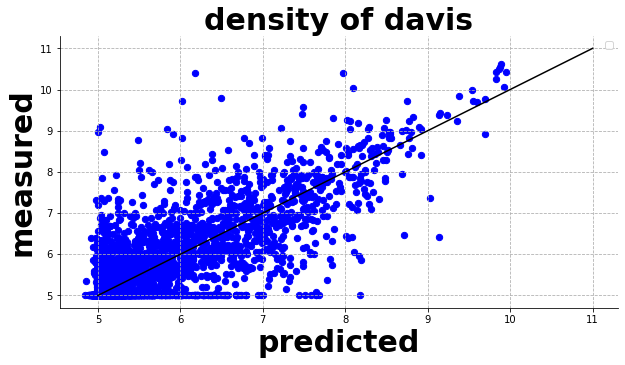

In [ ]:
import os
import sys
import torch
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
from torch_geometric.data import Batch

# from emetrics import get_aupr, get_cindex, get_rm2, get_ci, get_mse, get_rmse, get_pearson, get_spearman
# from utils import *
from scipy import stats
# from gnn import GNNNet
# from data_process import create_dataset_for_test

def predicting(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor().double()
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data_mol = data[0].to(device)
            data_pro = data[1].to(device)
            output = model(data_mol, data_pro)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data_pro.y.view(-1, 1).cpu()), 0)
    return total_labels.numpy().flatten(), total_preds.numpy().flatten()
 
 

def load_model(model_path):
    model = torch.load(model_path)
    return model


def calculate_metrics(Y, P, dataset='davis',results_dir):
    # aupr = get_aupr(Y, P)
    cindex = get_cindex(Y, P)  # DeepDTA
    cindex2 = get_ci(Y, P)  # GraphDTA
    rm2 = get_rm2(Y, P)  # DeepDTA
    mse = get_mse(Y, P)
    pearson = get_pearson(Y, P)
    spearman = get_spearman(Y, P)
    rmse = get_rmse(Y, P)

    print('metrics for ', dataset)
    # print('aupr:', aupr)
    print('cindex:', cindex)
    print('cindex2', cindex2)
    print('rm2:', rm2)
    print('mse:', mse)
    print('pearson', pearson)

    result_file_name = results_dir +'/result_' + model_st + '_' + dataset + '.txt'
    result_str = ''
    result_str += dataset + '\r\n'
    result_str += 'rmse:' + str(rmse) + ' ' + ' mse:' + str(mse) + ' ' + ' pearson:' + str(
        pearson) + ' ' + 'spearman:' + str(spearman) + ' ' + 'ci:' + str(cindex) + ' ' + 'rm2:' + str(rm2)
    print(result_str)
    open(result_file_name, 'w').writelines(result_str)


def plot_density(Y, P, fold=0, dataset='davis',results_dir):
    plt.figure(figsize=(10, 5))
    plt.grid(linestyle='--')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.scatter(P, Y, color='blue', s=40)
    plt.title('density of ' + dataset, fontsize=30, fontweight='bold')
    plt.xlabel('predicted', fontsize=30, fontweight='bold')
    plt.ylabel('measured', fontsize=30, fontweight='bold')
    # plt.xlim(0, 21)
    # plt.ylim(0, 21)
    if dataset == 'davis':
        plt.plot([5, 11], [5, 11], color='black')
    else:
        plt.plot([6, 16], [6, 16], color='black')
    # plt.legend()
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=12, fontweight='bold')
    plt.savefig(os.path.join(results_dir, dataset + '_' + str(fold) + '.png'), dpi=500, bbox_inches='tight')


if __name__ == '__main__':
    dataset = 'davis'  # dataset selection
    model_st = GNNNet.__name__
    print('dataset:', dataset)
    fold = 0
    cuda_name = 'cuda:0'  # gpu selection
    print('cuda_name:', cuda_name)

    TEST_BATCH_SIZE = 512
    models_dir = '/content/drive/My Drive/DGraphDTA/models'
    results_dir = '/content/drive/My Drive/DGraphDTA/results'

    device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
    model_file_name = models_dir+'/model_' + model_st + '_' + dataset + '_'+str(fold).model'
    result_file_name = results_dir+'/result_' + model_st + '_' + dataset + '.txt'

    model = GNNNet()
    model.to(device)
    state = torch.load(model_file_name)
    model.load_state_dict(state['state_dict'])

    # model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))
    # test_data = create_dataset_for_test(dataset)
    # test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              # collate_fn=collate)

    test_path = '/content/DGraphDTA/data/davis_test.csv'
    test_data = DTADatasetModified(test_path)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True,
                                                  collate_fn=collate)



    Y, P = predicting(model, device, test_loader)
    calculate_metrics(Y, P, dataset,results_dir)
    plot_density(Y, P, fold, dataset,results_dir)
